In [1]:
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import boxcox

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import seaborn as sns



We decided to analyze the impact of Fiscal policy on Unemployment for out project. how changing the Central Bank interest rate imapact Unemployment directly as explained in CFA level 1 curriculum.

-------------------------------------------------------------
## Data Preparation: Economic Indicators from FRED

This cell fetches monthly economic data from the Federal Reserve Economic Data (FRED) API, including variables like the Federal Funds Rate, M2 Money Supply, Inflation (CPI), GDP Growth Rate, and Unemployment Rate, starting from 1960. It renames the columns for readability, forward-fills quarterly GDP data to align with monthly frequency, removes any remaining missing values, and computes the percentage change of each variable to prepare the dataset for time-series modeling and causality analysis.

------------------------------------------------

In [2]:

# Define economic indicators
indicators = {
    "FEDFUNDS": "Federal Funds Rate",
    "M2SL": "M2 Money Supply",
    "CPIAUCSL": "Inflation (CPI)",
    "A191RL1Q225SBEA": "GDP Growth Rate",
    "UNRATE": "Unemployment Rate"
}

# Fetch data from FRED (starting from 1960)
df = pdr.get_data_fred(list(indicators.keys()), start="1960-01-01")

# Rename columns for readability
df.rename(columns=indicators, inplace=True)

# Forward fill GDP values to match monthly frequency
df["GDP Growth Rate"] = df["GDP Growth Rate"].ffill()

# Drop missing values
df.dropna(inplace=True)

# Convert to percentage changes for better causality detection
df_pct = df.pct_change().dropna()



In [3]:
df_pct

,Federal Funds Rate,M2 Money Supply,Inflation (CPI),GDP Growth Rate,Unemployment Rate
DATE,,,,,
1960-02-01,-0.005013,0.000671,0.001362,0.000000,-0.076923
1960-03-01,-0.032746,0.003016,0.000000,0.000000,0.125000
1960-04-01,0.020833,0.002673,0.004420,-1.225806,-0.037037
1960-05-01,-0.017857,0.002666,0.001016,0.000000,-0.019231
1960-06-01,-0.137662,0.004653,0.001353,0.000000,0.058824
...,...,...,...,...,...
2024-11-01,-0.039337,0.005573,0.002805,0.000000,0.024390
2024-12-01,-0.034483,0.001664,0.003647,0.000000,-0.023810
2025-01-01,-0.033482,0.004053,0.004669,0.000000,-0.024390


--------------------------------------------

## Time-Series Visualization of Macroeconomic Indicators

This cell plots the time-series trends of key macroeconomic indicators. It displays GDP Growth Rate, Unemployment Rate, and the Federal Funds Rate on the primary y-axis, while using secondary axes for M2 Money Supply (dashed red line) and Inflation (CPI, dotted green line) due to their different scales. This three-axis setup helps visualize long-term trends and compare variable behaviors over time without misleading scale distortions.

After that, another cell to split the plots into two comparing variabels with similar scales.

-------------------------------------------

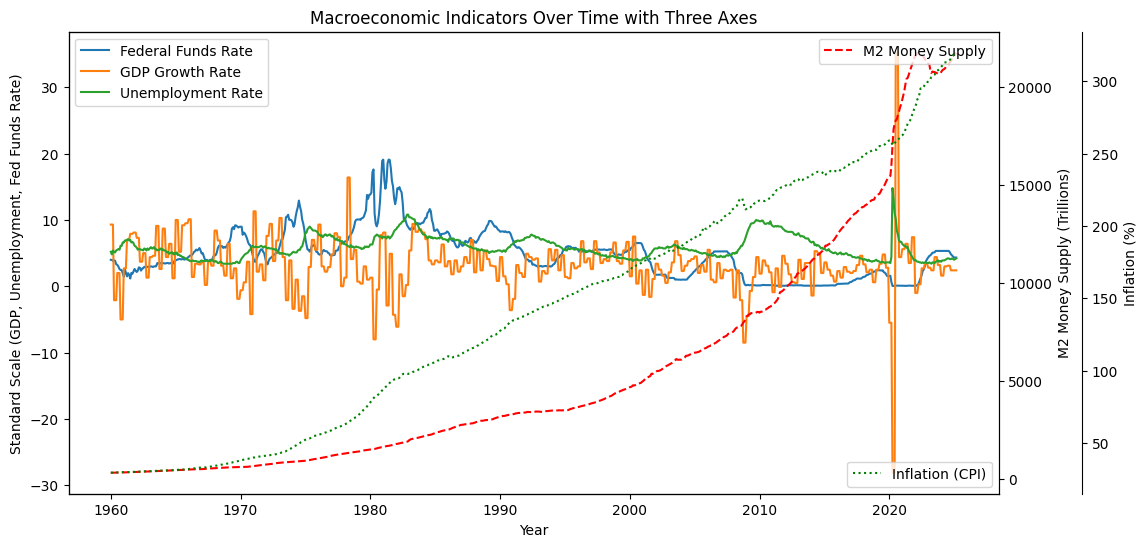

In [4]:

################## PLOT TIME-SERIES ######################

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot all variables EXCEPT M2 and Inflation on the primary axis
for col in df.columns:
    if col not in ["M2 Money Supply", "Inflation (CPI)"]:  # Exclude M2 & CPI
        ax1.plot(df.index, df[col], label=col)

ax1.set_ylabel("Standard Scale (GDP, Unemployment, Fed Funds Rate)")
ax1.set_xlabel("Year")
ax1.legend(loc="upper left")
ax1.set_title("Macroeconomic Indicators Over Time with Three Axes")

# Secondary axis (for M2 Money Supply)
ax2 = ax1.twinx()
ax2.plot(df.index, df["M2 Money Supply"], color="red", linestyle="dashed", label="M2 Money Supply")
ax2.set_ylabel("M2 Money Supply (Trillions)")
ax2.legend(loc="upper right")

# Third axis (for Inflation)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Move third axis to the right
ax3.plot(df.index, df["Inflation (CPI)"], color="green", linestyle="dotted", label="Inflation (CPI)")
ax3.set_ylabel("Inflation (%)")
ax3.legend(loc="lower right")

plt.show()



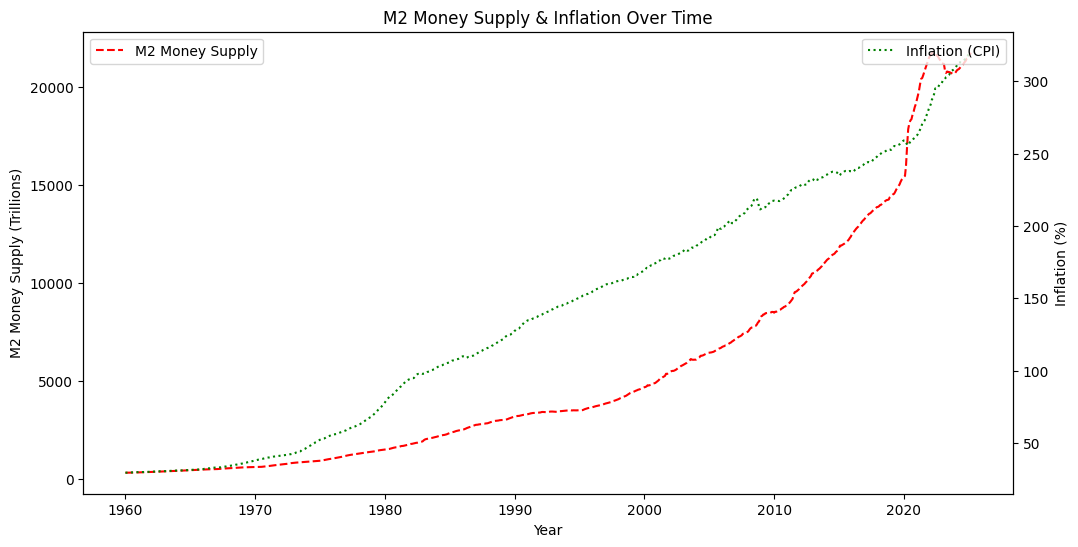

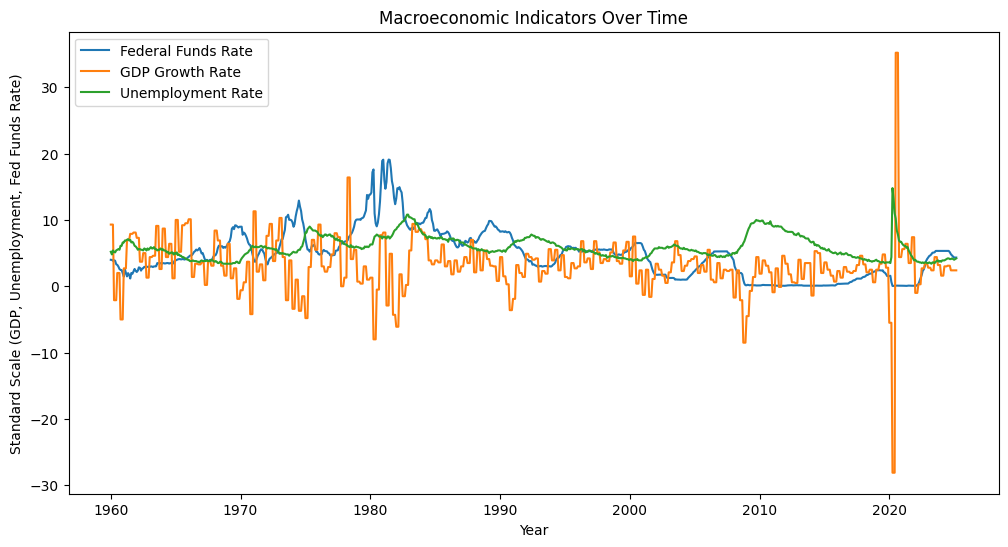

In [5]:
import matplotlib.pyplot as plt

# --- Plot 1: M2 Money Supply & Inflation (Two Axes) ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis for M2 Money Supply
ax1.plot(df.index, df["M2 Money Supply"], color="red", linestyle="dashed", label="M2 Money Supply")
ax1.set_ylabel("M2 Money Supply (Trillions)")
ax1.set_xlabel("Year")
ax1.set_title("M2 Money Supply & Inflation Over Time")
ax1.legend(loc="upper left")

# Secondary axis for Inflation
ax2 = ax1.twinx()
ax2.plot(df.index, df["Inflation (CPI)"], color="green", linestyle="dotted", label="Inflation (CPI)")
ax2.set_ylabel("Inflation (%)")
ax2.legend(loc="upper right")

plt.show()

# --- Plot 2: The Rest of the Indicators (Single Axis) ---
fig, ax3 = plt.subplots(figsize=(12, 6))

# Plot all other variables EXCEPT M2 and Inflation
for col in df.columns:
    if col not in ["M2 Money Supply", "Inflation (CPI)"]:
        ax3.plot(df.index, df[col], label=col)

ax3.set_ylabel("Standard Scale (GDP, Unemployment, Fed Funds Rate)")
ax3.set_xlabel("Year")
ax3.set_title("Macroeconomic Indicators Over Time")
ax3.legend(loc="upper left")

plt.show()


------------------------------

# Time Series Transformation: Achieving Stationarity

  
  In time series analysis, many statistical models (such as VAR models, Granger causality tests, impulse response analysis) require that the data be stationary. meaning that its mean, variance, and autocorrelation structure do not change over time.

However, most real-world economic indicators (like GDP growth, inflation, unemployment) are naturally non-stationary as we can infer from the previous plots.   

If we directly apply models to non-stationary data, we risk spurious regressions and invalid causal conclusions.  


1. Apply First Differencing:
We will compute the first differences of each series.

2. Confirm Stationarity:
Use Augmented Dickey-Fuller (ADF) Tests to statistically check whether the differenced data is stationary.


=== ADF Stationarity Tests ===
Federal Funds Rate: p-value = 0.0000 (Stationary)
M2 Money Supply: p-value = 0.0000 (Stationary)
Inflation (CPI): p-value = 0.0001 (Stationary)
GDP Growth Rate: p-value = 0.0000 (Stationary)
Unemployment Rate: p-value = 0.0000 (Stationary)


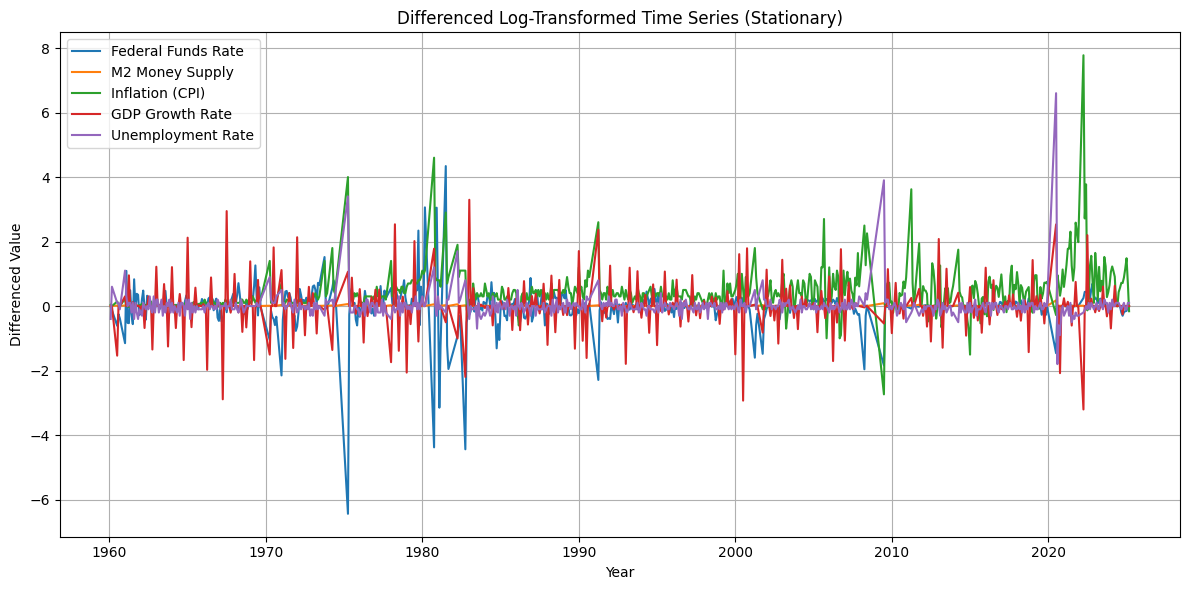

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Make a copy to avoid modifying original data
df_trans = df.copy()

# Step 1: Apply log transform safely
log_vars = ["M2 Money Supply", "GDP Growth Rate"]

for col in log_vars:
    # Replace non-positive values (<=0) temporarily to avoid log problems
    df_trans[col] = df_trans[col].apply(lambda x: x if x > 0 else np.nan)
    df_trans[col] = np.log(df_trans[col])

# Step 2: Drop rows with NaNs after log-transform
df_trans = df_trans.dropna()

# Step 3: Apply first differencing
df_diff = df_trans.diff().dropna()

# Step 4: Augmented Dickey-Fuller test to check for stationarity
print("=== ADF Stationarity Tests ===")
for col in df_diff.columns:
    result = adfuller(df_diff[col].dropna())
    print(f"{col}: p-value = {result[1]:.4f} {'(Stationary)' if result[1] < 0.05 else '(Non-stationary)'}")

# Step 5: Plot the differenced (stationary) data
plt.figure(figsize=(12, 6))
for col in df_diff.columns:
    plt.plot(df_diff.index, df_diff[col], label=col)

plt.title("Differenced Log-Transformed Time Series (Stationary)")
plt.xlabel("Year")
plt.ylabel("Differenced Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


----------------------------------------------------

## Granger Causality Tests Between Macroeconomic Variables

we have create a Direct Acyclic Graph (DAG) based on CFA curricilam theory, but upon reviewing and testing the claimed relations in traditional economicaltheory didn't perform well. Therefore, we have decided to directly test the casual relation directly between each variable and adjust the DAG accordingly.   


This cell defines and applies Granger causality tests to investigate potential predictive relationships between economic indicators. The Granger causality test checks whether past values of one time series (e.g., the Federal Funds Rate) contain useful information to forecast another time series (e.g., the Unemployment Rate), beyond what is contained in the past values of the second series alone.

Function granger_test(var1, var2) is defined to automate testing whether var1 Granger-causes var2 using up to 12 lags.

Multiple pairs of variables are tested, including:

*) Does the Federal Funds Rate predict Unemployment, Inflation, M2, or GDP?  

*) Does GDP Growth predict Inflation, Unemployment, and M2?  

*) Does M2 Money Supply predict Inflation, Unemployment, GDP, and Federal Funds Rate?  

*) Does Inflation predict other variables?  

*) Does Unemployment predict other variables?  


Each test prints a detailed statistical output (F-statistics and p-values for different lag lengths), helping determine whether causal (predictive) relationships exist at a statistically significant level.


This testing step helps narrow down which variables are likely to be causal drivers and which ones are more reactive, guiding later modeling decisions.



In [8]:
df_pct = df_diff #simple correction instead of changing all the code below.

In [9]:

# 1. Granger Causality Tests (Check which variables predict others)
def granger_test(var1, var2, max_lag=8):
    print(f"\nGranger causality test: {var1} → {var2}")
    result = grangercausalitytests(df_pct[[var2, var1]], maxlag=max_lag, verbose=True)
    return result


In [10]:

# Does FEDFUNDS cause Unemployment?
granger_test("Federal Funds Rate", "Unemployment Rate")
# Does FEDFUND cause inflation ? 
granger_test("Federal Funds Rate", "Inflation (CPI)")
# Does FEDFUND cause M2  ? 
granger_test("Federal Funds Rate", "M2 Money Supply")
# Does FEDFUND cause GDP  ? 
granger_test("Federal Funds Rate", "GDP Growth Rate")



Granger causality test: Federal Funds Rate → Unemployment Rate

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0079  , p=0.3158  , df_denom=682, df_num=1
ssr based chi2 test:   chi2=1.0124  , p=0.3143  , df=1
likelihood ratio test: chi2=1.0116  , p=0.3145  , df=1
parameter F test:         F=1.0079  , p=0.3158  , df_denom=682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4955  , p=0.6095  , df_denom=679, df_num=2
ssr based chi2 test:   chi2=0.9983  , p=0.6071  , df=2
likelihood ratio test: chi2=0.9975  , p=0.6073  , df=2
parameter F test:         F=0.4955  , p=0.6095  , df_denom=679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4465  , p=0.7199  , df_denom=676, df_num=3
ssr based chi2 test:   chi2=1.3533  , p=0.7165  , df=3
likelihood ratio test: chi2=1.3520  , p=0.7168  , df=3
parameter F test:         F=0.4465  , p=0.7199  , df_denom=676, df_num=3

Granger Causality
number of l

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(0.631123699649287),
    np.float64(0.4272197830707918),
    np.float64(682.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.6338999036066886),
    np.float64(0.4259284018296463),
    np.int64(1)),
   'lrtest': (np.float64(0.633606778528474),
    np.float64(0.42603540216181024),
    np.int64(1)),
   'params_ftest': (np.float64(0.6311236996495111),
    np.float64(0.4272197830707083),
    np.float64(682.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.5025344624934527),
    np.float64(0.6052202131511428),
    np.float64(679.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.0124700216362934),
    np.float64(0.6027606995721227),
    np.int64(2)),
   'lrtest': (np.float64(1.0117214214249088),
    np.float64(0.6029863551945069),
    np.int64(2)),
   'params_ftest': (np.float64(0.5025344624934875),
    np.float64(0.6052202131511202),
    np.float64(679.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
       

In [11]:

#Does GDP effect inflation,empl,M2?
granger_test("GDP Growth Rate", "Inflation (CPI)")
granger_test("GDP Growth Rate", "Unemployment Rate")
granger_test("GDP Growth Rate", "M2 Money Supply")
granger_test("GDP Growth Rate", "Inflation (CPI)")


c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger causality test: GDP Growth Rate → Inflation (CPI)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4502  , p=0.5025  , df_denom=682, df_num=1
ssr based chi2 test:   chi2=0.4522  , p=0.5013  , df=1
likelihood ratio test: chi2=0.4520  , p=0.5014  , df=1
parameter F test:         F=0.4502  , p=0.5025  , df_denom=682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3857  , p=0.6801  , df_denom=679, df_num=2
ssr based chi2 test:   chi2=0.7772  , p=0.6780  , df=2
likelihood ratio test: chi2=0.7767  , p=0.6782  , df=2
parameter F test:         F=0.3857  , p=0.6801  , df_denom=679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3763  , p=0.7701  , df_denom=676, df_num=3
ssr based chi2 test:   chi2=1.1405  , p=0.7673  , df=3
likelihood ratio test: chi2=1.1396  , p=0.7675  , df=3
parameter F test:         F=0.3763  , p=0.7701  , df_denom=676, df_num=3

Granger Causality
number of lags (

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(0.45019356646090175),
    np.float64(0.5024702144099259),
    np.float64(682.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.4521738900670348),
    np.float64(0.5013044124449714),
    np.int64(1)),
   'lrtest': (np.float64(0.4520247139400908),
    np.float64(0.5013750149907216),
    np.int64(1)),
   'params_ftest': (np.float64(0.4501935664609488),
    np.float64(0.5024702144099259),
    np.float64(682.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.38574747543645416),
    np.float64(0.6800911172378308),
    np.float64(679.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.7771760624404556),
    np.float64(0.6780135328940429),
    np.int64(2)),
   'lrtest': (np.float64(0.7767348742088416),
    np.float64(0.6781631151877172),
    np.int64(2)),
   'params_ftest': (np.float64(0.3857474754363853),
    np.float64(0.680091117237882),
    np.float64(679.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
     

In [12]:


#Does M2 effect the rest?
granger_test("M2 Money Supply", "Inflation (CPI)")
granger_test("M2 Money Supply", "Unemployment Rate")
granger_test("M2 Money Supply", "GDP Growth Rate")
granger_test("M2 Money Supply", "Federal Funds Rate")



Granger causality test: M2 Money Supply → Inflation (CPI)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1740  , p=0.6767  , df_denom=682, df_num=1
ssr based chi2 test:   chi2=0.1748  , p=0.6759  , df=1
likelihood ratio test: chi2=0.1748  , p=0.6759  , df=1
parameter F test:         F=0.1740  , p=0.6767  , df_denom=682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0788  , p=0.9242  , df_denom=679, df_num=2
ssr based chi2 test:   chi2=0.1588  , p=0.9237  , df=2
likelihood ratio test: chi2=0.1588  , p=0.9237  , df=2
parameter F test:         F=0.0788  , p=0.9242  , df_denom=679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0778  , p=0.9720  , df_denom=676, df_num=3
ssr based chi2 test:   chi2=0.2359  , p=0.9716  , df=3
likelihood ratio test: chi2=0.2359  , p=0.9716  , df=3
parameter F test:         F=0.0778  , p=0.9720  , df_denom=676, df_num=3

Granger Causality
number of lags (

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=0.3202  , p=0.9585  , df_denom=661, df_num=8
ssr based chi2 test:   chi2=2.6276  , p=0.9555  , df=8
likelihood ratio test: chi2=2.6225  , p=0.9558  , df=8
parameter F test:         F=0.3202  , p=0.9585  , df_denom=661, df_num=8

Granger causality test: M2 Money Supply → Unemployment Rate

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1324 , p=0.0015  , df_denom=682, df_num=1
ssr based chi2 test:   chi2=10.1770 , p=0.0014  , df=1
likelihood ratio test: chi2=10.1021 , p=0.0015  , df=1
parameter F test:         F=10.1324 , p=0.0015  , df_denom=682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0086  , p=0.0004  , df_denom=679, df_num=2
ssr based chi2 test:   chi2=16.1351 , p=0.0003  , df=2
likelihood ratio test: chi2=15.9477 , p=0.0003  , df=2
parameter F test:         F=8.0086  , p=0.0004  , df_denom=679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.249

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(0.335047947211317),
    np.float64(0.5628927946782896),
    np.float64(682.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.3365217651609269),
    np.float64(0.5618438388214981),
    np.int64(1)),
   'lrtest': (np.float64(0.33643913025412076),
    np.float64(0.5618918705140905),
    np.int64(1)),
   'params_ftest': (np.float64(0.3350479472112321),
    np.float64(0.5628927946783777),
    np.float64(682.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.11065326967193523),
    np.float64(0.8952652454585677),
    np.float64(679.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.22293618985450278),
    np.float64(0.8945199306714549),
    np.int64(2)),
   'lrtest': (np.float64(0.22289986693931496),
    np.float64(0.8945361766047671),
    np.int64(2)),
   'params_ftest': (np.float64(0.1106532696718894),
    np.float64(0.8952652454586015),
    np.float64(679.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
   

In [13]:

#Does inflation effect the rest?
granger_test("Inflation (CPI)", "M2 Money Supply")
granger_test("Inflation (CPI)", "Unemployment Rate")
granger_test("Inflation (CPI)", "GDP Growth Rate")
granger_test("Inflation (CPI)", "Federal Funds Rate")



Granger causality test: Inflation (CPI) → M2 Money Supply

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1448  , p=0.7037  , df_denom=682, df_num=1
ssr based chi2 test:   chi2=0.1454  , p=0.7029  , df=1
likelihood ratio test: chi2=0.1454  , p=0.7029  , df=1
parameter F test:         F=0.1448  , p=0.7037  , df_denom=682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0967  , p=0.9079  , df_denom=679, df_num=2
ssr based chi2 test:   chi2=0.1947  , p=0.9072  , df=2
likelihood ratio test: chi2=0.1947  , p=0.9072  , df=2
parameter F test:         F=0.0967  , p=0.9079  , df_denom=679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3729  , p=0.0181  , df_denom=676, df_num=3
ssr based chi2 test:   chi2=10.2233 , p=0.0168  , df=3
likelihood ratio test: chi2=10.1476 , p=0.0174  , df=3
parameter F test:         F=3.3729  , p=0.0181  , df_denom=676, df_num=3

Granger Causality
number of lags (

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=2.7810  , p=0.0050  , df_denom=661, df_num=8
ssr based chi2 test:   chi2=22.8203 , p=0.0036  , df=8
likelihood ratio test: chi2=22.4446 , p=0.0042  , df=8
parameter F test:         F=2.7810  , p=0.0050  , df_denom=661, df_num=8

Granger causality test: Inflation (CPI) → Unemployment Rate

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3697  , p=0.0370  , df_denom=682, df_num=1
ssr based chi2 test:   chi2=4.3889  , p=0.0362  , df=1
likelihood ratio test: chi2=4.3749  , p=0.0365  , df=1
parameter F test:         F=4.3697  , p=0.0370  , df_denom=682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3078  , p=0.1003  , df_denom=679, df_num=2
ssr based chi2 test:   chi2=4.6496  , p=0.0978  , df=2
likelihood ratio test: chi2=4.6339  , p=0.0986  , df=2
parameter F test:         F=2.3078  , p=0.1003  , df_denom=679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.318

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


parameter F test:         F=0.7492  , p=0.5230  , df_denom=676, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7904  , p=0.5316  , df_denom=673, df_num=4
ssr based chi2 test:   chi2=3.2040  , p=0.5243  , df=4
likelihood ratio test: chi2=3.1965  , p=0.5255  , df=4
parameter F test:         F=0.7904  , p=0.5316  , df_denom=673, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6702  , p=0.6462  , df_denom=670, df_num=5
ssr based chi2 test:   chi2=3.4059  , p=0.6377  , df=5
likelihood ratio test: chi2=3.3974  , p=0.6390  , df=5
parameter F test:         F=0.6702  , p=0.6462  , df_denom=670, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5622  , p=0.7605  , df_denom=667, df_num=6
ssr based chi2 test:   chi2=3.4391  , p=0.7521  , df=6
likelihood ratio test: chi2=3.4304  , p=0.7532  , df=6
parameter F test:         F=0.5622  , p=0.7605  , df_denom=667, df_num=6

Granger Causality
nu

{np.int64(1): ({'ssr_ftest': (np.float64(0.47962978930775596),
    np.float64(0.4888257938546319),
    np.float64(682.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.48173959776512143),
    np.float64(0.4876354051916969),
    np.int64(1)),
   'lrtest': (np.float64(0.4815702807645721),
    np.float64(0.4877119036326437),
    np.int64(1)),
   'params_ftest': (np.float64(0.47962978930768585),
    np.float64(0.4888257938547007),
    np.float64(682.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.5289494882960105),
    np.float64(0.5894662234867352),
    np.float64(679.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.0656891016037444),
    np.float64(0.5869330320230389),
    np.int64(2)),
   'lrtest': (np.float64(1.0648597777642408),
    np.float64(0.5871764612677943),
    np.int64(2)),
   'params_ftest': (np.float64(0.5289494882958554),
    np.float64(0.5894662234868465),
    np.float64(679.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
   

In [14]:

#Does Emp% effect the rest?
granger_test("Unemployment Rate", "Inflation (CPI)")
granger_test("Unemployment Rate", "M2 Money Supply")
granger_test("Unemployment Rate", "GDP Growth Rate")
granger_test("Unemployment Rate", "Federal Funds Rate")



Granger causality test: Unemployment Rate → Inflation (CPI)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0102  , p=0.9195  , df_denom=682, df_num=1
ssr based chi2 test:   chi2=0.0103  , p=0.9193  , df=1
likelihood ratio test: chi2=0.0103  , p=0.9193  , df=1
parameter F test:         F=0.0102  , p=0.9195  , df_denom=682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1669  , p=0.8463  , df_denom=679, df_num=2
ssr based chi2 test:   chi2=0.3363  , p=0.8452  , df=2
likelihood ratio test: chi2=0.3362  , p=0.8453  , df=2
parameter F test:         F=0.1669  , p=0.8463  , df_denom=679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2587  , p=0.8552  , df_denom=676, df_num=3
ssr based chi2 test:   chi2=0.7840  , p=0.8533  , df=3
likelihood ratio test: chi2=0.7836  , p=0.8534  , df=3
parameter F test:         F=0.2587  , p=0.8552  , df_denom=676, df_num=3

Granger Causality
number of lags

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


parameter F test:         F=0.8447  , p=0.5504  , df_denom=664, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7499  , p=0.6473  , df_denom=661, df_num=8
ssr based chi2 test:   chi2=6.1539  , p=0.6300  , df=8
likelihood ratio test: chi2=6.1261  , p=0.6331  , df=8
parameter F test:         F=0.7499  , p=0.6473  , df_denom=661, df_num=8

Granger causality test: Unemployment Rate → M2 Money Supply

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6450  , p=0.0567  , df_denom=682, df_num=1
ssr based chi2 test:   chi2=3.6611  , p=0.0557  , df=1
likelihood ratio test: chi2=3.6513  , p=0.0560  , df=1
parameter F test:         F=3.6450  , p=0.0567  , df_denom=682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9424  , p=0.3902  , df_denom=679, df_num=2
ssr based chi2 test:   chi2=1.8986  , p=0.3870  , df=2
likelihood ratio test: chi2=1.8960  , p=0.3875  , df=2
parameter F test:         F=0.942

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=1.0830  , p=0.3392  , df_denom=679, df_num=2
ssr based chi2 test:   chi2=2.1819  , p=0.3359  , df=2
likelihood ratio test: chi2=2.1784  , p=0.3365  , df=2
parameter F test:         F=1.0830  , p=0.3392  , df_denom=679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2063  , p=0.3066  , df_denom=676, df_num=3
ssr based chi2 test:   chi2=3.6562  , p=0.3011  , df=3
likelihood ratio test: chi2=3.6465  , p=0.3023  , df=3
parameter F test:         F=1.2063  , p=0.3066  , df_denom=676, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9012  , p=0.4628  , df_denom=673, df_num=4
ssr based chi2 test:   chi2=3.6531  , p=0.4550  , df=4
likelihood ratio test: chi2=3.6433  , p=0.4564  , df=4
parameter F test:         F=0.9012  , p=0.4628  , df_denom=673, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1554  , p=0.3298  , df_denom=670, df_num=5
ssr based chi2 test: 

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(1.9686457286095036),
    np.float64(0.16104677548325277),
    np.float64(682.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.9773054605535336),
    np.float64(0.15967455891479862),
    np.int64(1)),
   'lrtest': (np.float64(1.974457118000828),
    np.float64(0.15997555773350114),
    np.int64(1)),
   'params_ftest': (np.float64(1.9686457286095396),
    np.float64(0.16104677548325277),
    np.float64(682.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.8480547382639458),
    np.float64(0.1583348774648295),
    np.float64(679.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(3.7233267775332517),
    np.float64(0.1554139015063687),
    np.int64(2)),
   'lrtest': (np.float64(3.713229513099577),
    np.float64(0.15620051312202318),
    np.int64(2)),
   'params_ftest': (np.float64(1.8480547382638979),
    np.float64(0.15833487746484193),
    np.float64(679.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
  

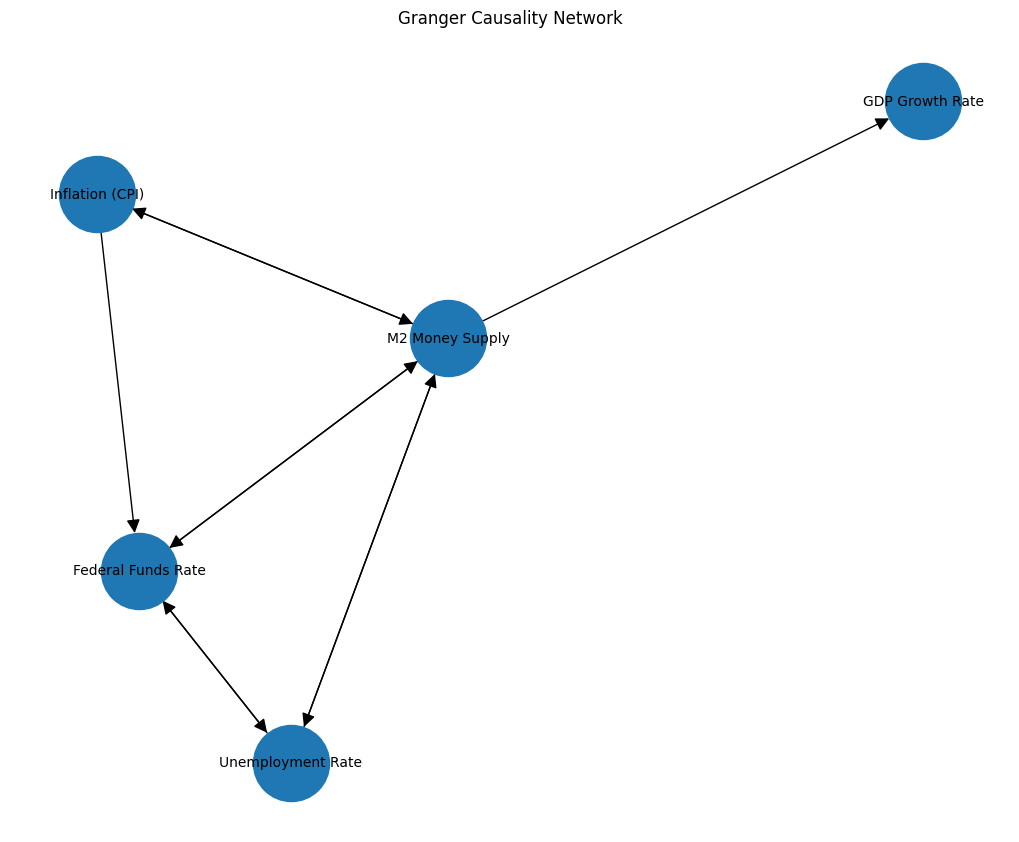

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes (variables)
variables = [
    "Federal Funds Rate",
    "Unemployment Rate",
    "Inflation (CPI)",
    "M2 Money Supply",
    "GDP Growth Rate"
]
G.add_nodes_from(variables)

# Add edges (Granger-causal relationships)
edges = [
    ("Federal Funds Rate", "Unemployment Rate"),
    ("Federal Funds Rate", "M2 Money Supply"),
    ("M2 Money Supply", "Inflation (CPI)"),
    ("M2 Money Supply", "Unemployment Rate"),
    ("M2 Money Supply", "GDP Growth Rate"),
    ("M2 Money Supply", "Federal Funds Rate"),
    ("Inflation (CPI)", "M2 Money Supply"),
    ("Inflation (CPI)", "Federal Funds Rate"),
    ("Unemployment Rate", "M2 Money Supply"),
    ("Unemployment Rate", "Federal Funds Rate")
]
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10, arrowsize=20)
plt.title("Granger Causality Network")
plt.show()


## Result Summary 

*) Federal Funds Rate Granger-causes Unemployment and M2 Money Supply strongly.

*) M2 Money Supply Granger-causes almost everything (Inflation, Unemployment, GDP, even Federal Funds Rate).

*) Inflation causes M2 and Federal Funds Rate, but not Unemployment or GDP.

*) GDP Growth does not Granger-cause anything strongly.

The Granger tests show that when the Federal Funds Rate moves, it heavily impacts unemployment and money supply. Then M2 (money supply) takes over, pushing inflation, unemployment, and even GDP around. There’s some two-way action too — inflation and unemployment can push back a bit on M2 and the Fed Rate, but overall, it’s clear that monetary policy and liquidity are steering the ship. GDP itself doesn’t seem to lead much. it’s mostly reacting.

Thus, DAG was updated according to our new findings

------------------------------------------------------

# Further Data Exploration

Here, we created a correlation matrix with a heatmap, to visualize the pairwise relationships between all the economic indicators. Strong and weak correlations should be clear and visible


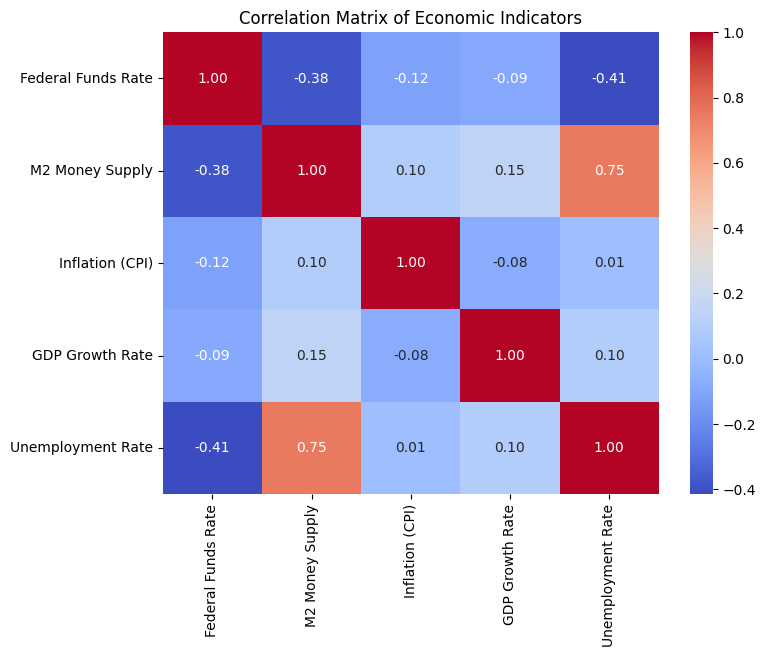

In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Check for multicollinearity using pairwise correlation
corr_matrix = df_pct.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Economic Indicators")
plt.show()


## Johansen Cointegration Test

The Johansen test checks whether a group of time series variables move together in the long run meaning they are cointegrated. and it can handle multiple variables together in one shot.

We run the Johansen Cointegration Test to check if there are long-term relationships between our economic variables. Even if two or more variables move randomly in the short term, they might still be tied together in the long run. 


Data for Johansan should be the original non-transformed data (non-stationary is fine, infact it is needed)


In [17]:
# 2. Johansen Cointegration Test (Check for long-term relationships)
print("\nJohansen Cointegration Test Results:")
print(coint_johansen(df, det_order=0, k_ar_diff=1).eig) #just test samplem, below is real test



Johansen Cointegration Test Results:
[0.36291459 0.08543647 0.06377668 0.01944672 0.00285582]


In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

result = coint_johansen(df, det_order=0, k_ar_diff=1)

print("Trace Statistic:", result.trace_stat)
print("Critical Values:", result.trace_stat_crit_vals)


Trace Statistic: [490.9048313  138.78977619  69.03996385  17.5710935    2.2335869 ]
Critical Values: [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


### Johansen test result :

The Johansen cointegration test shows that all trace statistics are way above their critical values at all conventional confidence levels (90%, 95%, and 99%).
This strongly suggests that there are multiple cointegrating relationships among the variables.  

In simple terms: these variables aren't just randomly moving together short-term, they seem to be linked long-term too.

----------------------------------------

--------------------------------------------------------------------------------------
### Causal Relationship Between Economic Indicators

#### **Causal Expression:**
$
P(\text{Unemployment\%} \mid do(\text{Fed Fund Rate})) =
\sum_{\text{M2}, \text{GDP}, \text{Inflation}}
P(\text{Unemployment\%} \mid \text{M2}) 
P(\text{M2} \mid \text{GDP}, \text{Inflation}) 
P(\text{GDP} \mid \text{Fed Fund Rate}) 
P(\text{M2} \mid \text{Fed Fund Rate})
P(\text{Inflation})
$

#### **Explanation:**
- $ P(\text{Unemployment\%} \mid \text{M2}) $ → **Unemployment** is primarily affected by **Money Supply (M2)**.
- $ P(\text{M2} \mid \text{GDP}, \text{Inflation}) $ → **M2 is influenced by both GDP and Inflation**.
- $ P(\text{GDP} \mid \text{Fed Fund Rate}) $ → **GDP responds to interest rate changes**.
- $ P(\text{M2} \mid \text{Fed Fund Rate}) $ → **M2 reacts to interest rate shifts**.
- $ P(\text{Inflation}) $ → **Inflation is exogenous**.
---

### **Backdoor Criterion: Adjusting for Confounding**
To **block reverse causality** (where **Unemployment influences the Fed Fund Rate**), we condition on **Unemployment%** in the adjustment set.

Thus, the final estimation remains:

$
P(\text{Unemployment\%} \mid do(\text{Fed Fund Rate})) =
\sum_{\text{Inflation}, \text{M2}, \text{GDP}}
P(\text{Unemployment\%} \mid \text{M2}) 
P(\text{M2} \mid \text{GDP}, \text{Inflation}) 
P(\text{GDP} \mid \text{Fed Fund Rate}) 
P(\text{M2} \mid \text{Fed Fund Rate})
P(\text{Inflation})
$


-------------------------------------------------------------------------------

## Modeling the Probability Distirbutions

To obtain the probability distributions needed for the **do-calculus** applications discussed above, we need to model the data and extract the joint probability structure from it.  

Since a linear model* provides the conditional expectation of a variable :

$$
E[Y \mid X] = \text{linear function of } X
$$

we will use linear regression to model the relationships where it is appropriate.  

However, in cases where the variables are strongly cointegrated, simple linear regression is not sufficient. In these cases, we will instead use **Vector Autoregression (VAR), which will be explained below.



--------------------------------------------------------------------------------------------

### VAR (Vector Autoregression) 

VAR is a model where multiple time series are predicted together, using their own past values and the past values of each other.
Instead of modeling each variable separately, VAR lets us capture their dynamic interactions over time.

In this case, we're modeling Inflation (CPI) and M2 Money Supply together.
The idea is to understand how changes in one (like inflation spikes or money supply expansions) affect the other over time, across several lags.

We use VAR because Inflation (CPI) and M2 Money Supply are strongly cointegrated as shown by the Johansen test.

Thus, We want to quantify their influence on each other dynamically.

In [19]:
from statsmodels.api import OLS, add_constant


# Check the new DAG* and relevant joint distirbution P(V). then :
from statsmodels.tsa.api import VAR

# Select Inflation and M2 Money Supply
df_var = df_pct[["Inflation (CPI)", "M2 Money Supply"]]

# Fit VAR model (lag=1 for simplicity)
var_model = VAR(df_var)

# lag_selection = var_model.select_order(maxlags=12)  # test up to 12 lags, or however many you want
# print(lag_selection.summary()) 

var_result = var_model.fit(maxlags=5) #based on lag_selection above

print("\nVAR Model for P(Inflation, M2):")
print(var_result.summary())






VAR Model for P(Inflation, M2):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Apr, 2025
Time:                     14:15:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.3528
Nobs:                     681.000    HQIC:                  -10.4424
Log likelihood:           1664.30    FPE:                2.75652e-05
AIC:                     -10.4990    Det(Omega_mle):     2.66959e-05
--------------------------------------------------------------------
Results for equation Inflation (CPI)
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.186049         0.039946            4.657           0.000
L1.Inflation (CPI)         0.280296         0.038819            7.221           0.0

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### VAR result 
  
  Inflation mostly feeds on its own past but gets nudged around by changes in M2 Money Supply, especially after 2–3 months.
  
Meanwhile, M2 grows mostly by itself, but when inflation kicks in, M2’s behavior slightly changes, slowing down immediately but growing again after a few months.

In [20]:
X_fed = df_pct[["Inflation (CPI)", "Unemployment Rate", "M2 Money Supply"]]
X_fed = sm.add_constant(X_fed)  # Add intercept
model_fed = sm.OLS(df_pct["Federal Funds Rate"], X_fed).fit()

print("\nRegression for P(Fed Fund Rate | Inflation, Unemployment, M2):")
print(model_fed.summary())





Regression for P(Fed Fund Rate | Inflation, Unemployment, M2):
                            OLS Regression Results                            
Dep. Variable:     Federal Funds Rate   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     54.88
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           8.72e-32
Time:                        14:15:40   Log-Likelihood:                -509.28
No. Observations:                 686   AIC:                             1027.
Df Residuals:                     682   BIC:                             1045.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [21]:
X_gdp = df_pct[["Federal Funds Rate", "M2 Money Supply"]]
X_gdp = sm.add_constant(X_gdp)  # Add intercept
model_gdp = sm.OLS(df_pct["GDP Growth Rate"], X_gdp).fit()

print("\nRegression for P(GDP | Fed Fund Rate, M2):")
print(model_gdp.summary())




Regression for P(GDP | Fed Fund Rate, M2):
                            OLS Regression Results                            
Dep. Variable:        GDP Growth Rate   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     7.968
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           0.000379
Time:                        14:15:40   Log-Likelihood:                -598.80
No. Observations:                 686   AIC:                             1204.
Df Residuals:                     683   BIC:                             1217.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [22]:
X_unemp = df_pct[["M2 Money Supply"]]
X_unemp = sm.add_constant(X_unemp)  # Add intercept
model_unemp = sm.OLS(df_pct["Unemployment Rate"], X_unemp).fit()

print("\nRegression for P(Unemployment% | M2):")
print(model_unemp.summary())


Regression for P(Unemployment% | M2):
                            OLS Regression Results                            
Dep. Variable:      Unemployment Rate   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     862.8
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          2.57e-123
Time:                        14:15:40   Log-Likelihood:                -33.937
No. Observations:                 686   AIC:                             71.87
Df Residuals:                     684   BIC:                             80.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
con

-----------------------------------------------------------------

### Constructing the Estimated Joint Probability P(V)

Now that we have an understanding of the structure of our new DAG, we proceed to model the joint probability distribution $$ P(V) $$ over all variables of interest.

Here is the approach:

- 🔹 Step 1: Since Inflation and M2 Money Supply are strongly cointegrated (as seen from the Johansen test), we model them jointly using a VAR model. This captures the dynamic, time-dependent relationship between them.

- 🔹 Step 2: To model the conditional relationships, we use linear regression (OLS):
  - $$ P(\text{Fed Funds Rate} \mid \text{Inflation}, \text{Unemployment}, \text{M2}) $$
  - $$ P(\text{GDP Growth Rate} \mid \text{Fed Funds Rate}, \text{M2}) $$
  - $$ P(\text{Unemployment Rate} \mid \text{M2}) $$

- 🔹 Step 3: After fitting these models, we predict the values for each variable based on their parent nodes (according to the DAG structure).

- 🔹 Step 4: The joint probability is approximated by multiplying the fitted conditional probabilities across all variables:

$$
P(V) \approx P(\text{Inflation}, \text{M2}) \times P(\text{Fed Funds Rate} \mid \text{Inflation}, \text{Unemployment}, \text{M2}) \times P(\text{GDP} \mid \text{Fed Funds Rate}, \text{M2}) \times P(\text{Unemployment Rate} \mid \text{M2})
$$

- 🔹 Step 5: Finally, we normalize the resulting joint probability array so that the total sum equals 1, making it a valid probability distribution.

This gives us a full, empirical estimate of the joint distribution $$ P(V) $$ based on the modeled dependencies observed in the data.

We also visualize the distribution to check its shape and spread.


            Federal Funds Rate  M2 Money Supply  Inflation (CPI)  \
DATE                                                               
1960-02-01               -0.02         0.000670             0.04   
1960-03-01               -0.13         0.003012             0.00   
1960-07-01               -0.61         0.015910             0.14   
1960-08-01               -0.25         0.009165             0.06   
1960-09-01               -0.38         0.004876             0.00   

            GDP Growth Rate  Unemployment Rate  
DATE                                            
1960-02-01         0.000000               -0.4  
1960-03-01         0.000000                0.6  
1960-07-01        -1.536867                0.1  
1960-08-01         0.000000                0.1  
1960-09-01         0.000000               -0.1  

VAR Model for P(Inflation, M2):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Apr, 2025
Time:  

c:\Users\xoj\anaconda3\envs\ML808Proj\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


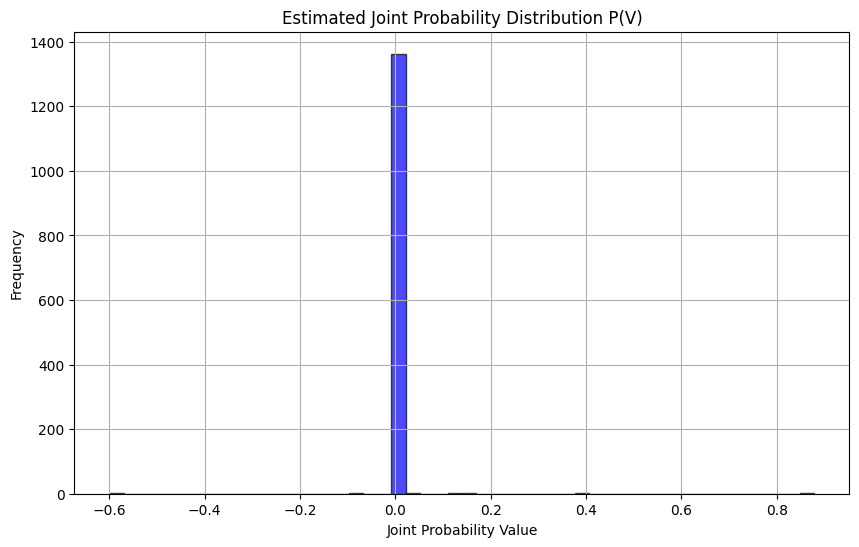

In [23]:
# Joint Probability of our new DAG :

# Display first few rows
print(df_pct.head())

# ===========================
# 🔹 1. Estimate Joint Distribution of Inflation & M2 (VAR Model)
# ===========================
df_var = df_pct[["Inflation (CPI)", "M2 Money Supply"]]
var_model = VAR(df_var)
var_result = var_model.fit(maxlags=1)  # Fit with lag=1 for simplicity
inflation_m2_pred = var_result.fittedvalues  # Fitted values from VAR model

print("\nVAR Model for P(Inflation, M2):")
print(var_result.summary())

# ===========================
# 🔹 2. Estimate P(Fed Fund Rate | Inflation, Unemployment, M2) (OLS)
# ===========================
X_fed = df_pct[["Inflation (CPI)", "Unemployment Rate", "M2 Money Supply"]]
X_fed = sm.add_constant(X_fed)  
model_fed = sm.OLS(df_pct["Federal Funds Rate"], X_fed).fit()
fed_fund_pred = model_fed.predict(X_fed)

print("\nRegression for P(Fed Fund Rate | Inflation, Unemployment):")
print(model_fed.summary())

# ===========================
# 🔹 3. Estimate P(GDP | Fed Fund Rate, M2 ) (OLS)
# ===========================
X_gdp = df_pct[["Federal Funds Rate", "M2 Money Supply"]]
X_gdp = sm.add_constant(X_gdp)  
model_gdp = sm.OLS(df_pct["GDP Growth Rate"], X_gdp).fit()
gdp_pred = model_gdp.predict(X_gdp)

print("\nRegression for P(GDP | Fed Fund Rate):")
print(model_gdp.summary())

# ===========================
# 🔹 4. Estimate P(Unemployment% | M2) (OLS)
# ===========================
X_unemp = df_pct[["M2 Money Supply"]]
X_unemp = sm.add_constant(X_unemp)  
model_unemp = sm.OLS(df_pct["Unemployment Rate"], X_unemp).fit()
unemployment_pred = model_unemp.predict(X_unemp)

print("\nRegression for P(Unemployment% | M2):")
print(model_unemp.summary())

# ===========================
# 🔹 5. Compute the Joint Probability Distribution
# ===========================
# Convert all predictions to NumPy arrays
inflation_m2_array = inflation_m2_pred.to_numpy()
fed_fund_array = fed_fund_pred.to_numpy()
gdp_array = gdp_pred.to_numpy()
unemployment_array = unemployment_pred.to_numpy()

# Align all arrays to the shortest length
min_len = min(len(inflation_m2_array), len(fed_fund_array), len(gdp_array), len(unemployment_array))

# Trim all arrays to the same length
inflation_m2_array = inflation_m2_array[:min_len]
fed_fund_array = fed_fund_array[:min_len]
gdp_array = gdp_array[:min_len]
unemployment_array = unemployment_array[:min_len]

# Ensure correct shape for multiplication
fed_fund_array = fed_fund_array.reshape(-1, 1)
gdp_array = gdp_array.reshape(-1, 1)
unemployment_array = unemployment_array.reshape(-1, 1)

# Compute the joint probability distribution
joint_prob = inflation_m2_array * fed_fund_array * gdp_array * unemployment_array

# Normalize to sum to 1
joint_prob /= joint_prob.sum()

print("\nJoint Probability Distribution P(V):")
print(joint_prob)



# ===========================
# 🔹 6. Plot the Joint Probability Distribution
# ===========================
plt.figure(figsize=(10, 6))
plt.hist(joint_prob.flatten(), bins=50, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Joint Probability Value")
plt.ylabel("Frequency")
plt.title("Estimated Joint Probability Distribution P(V)")
plt.grid(True)
plt.show()


Unusable Distirbution

-----------------------------------------------------------------

### Change of Approach: From Model-Based Estimation to Kernel Density Estimation (KDE)

Initially, we attempted to construct the joint probability distribution $ P(V) $ by modeling the conditional dependencies through VAR and linear regression, and then multiplying the fitted values accordingly.

However, the resulting joint probability estimate was highly Concetrated and not usable for our purposes.

Because of this, we decided to change the approach: instead of relying on fitted models, we now estimate the full joint distribution directly using Kernel Density Estimation (KDE) 

KDE provides a smooth, non-parametric estimate of the underlying probability density, and is better suited when the goal is to reconstruct an unknown distribution from observed samples without strong modeling assumptions.


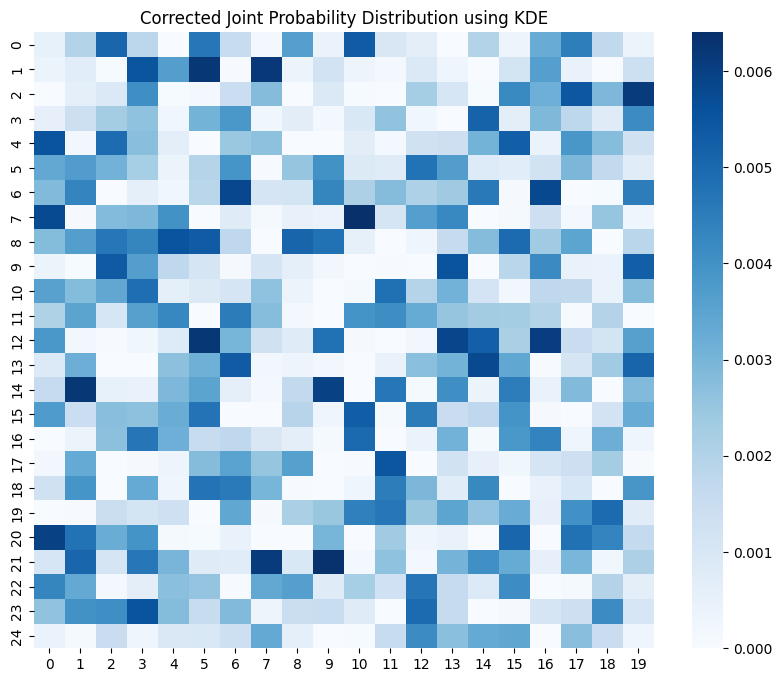

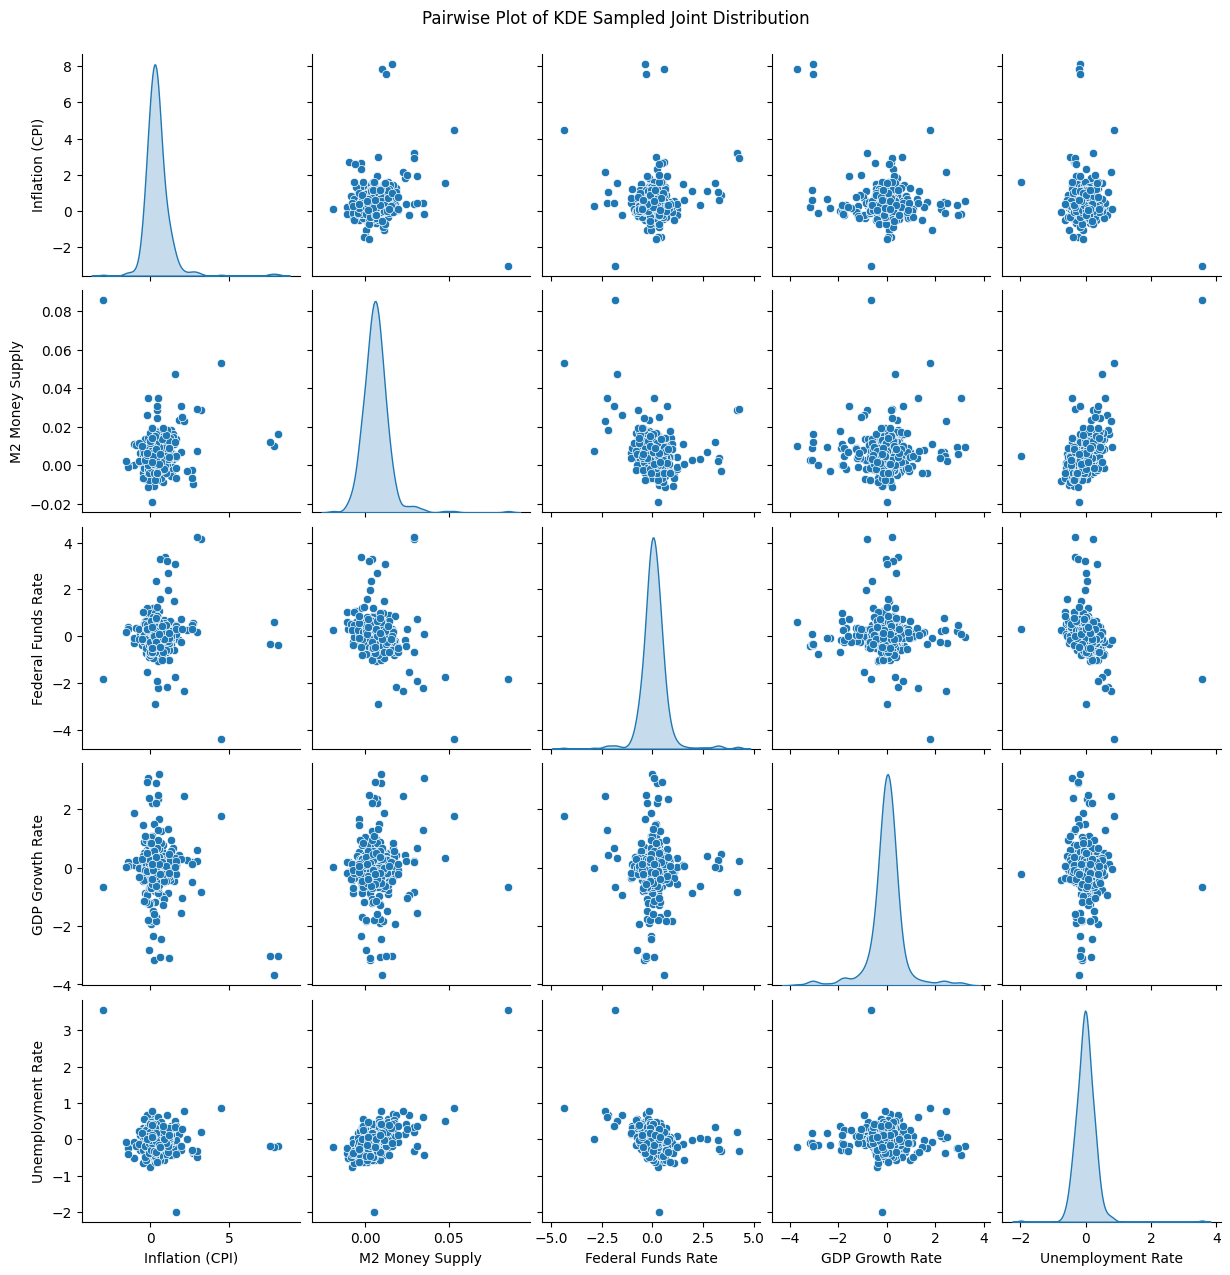

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Select the variables for joint distribution estimation
selected_vars = ["Inflation (CPI)", "M2 Money Supply", "Federal Funds Rate", "GDP Growth Rate", "Unemployment Rate"]
df_selected = df_pct[selected_vars]

# Compute Kernel Density Estimation (KDE) for joint distribution
kde = gaussian_kde(df_selected.T)  # Transpose to match KDE input requirements

# Generate a grid for visualization
num_samples = 500
sampled_data = np.array([df_selected[col].sample(num_samples, replace=True).values for col in selected_vars]).T

# Evaluate KDE on sampled data
joint_prob_kde = kde(sampled_data.T)

# Normalize joint probability to sum to 1
joint_prob_kde /= np.sum(joint_prob_kde)

# Plot KDE-based Joint Distribution as a Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(joint_prob_kde.reshape(25, 20), cmap="Blues", annot=False)
plt.title("Corrected Joint Probability Distribution using KDE")
plt.show()

# Sample points from KDE model
sampled_points = kde.resample(500).T  # Shape (500, 5)

# Put into DataFrame for Seaborn
sampled_df = pd.DataFrame(sampled_points, columns=selected_vars)

# Pairplot
sns.pairplot(sampled_df, diag_kind="kde")
plt.suptitle("Pairwise Plot of KDE Sampled Joint Distribution", y=1.02)
plt.show()


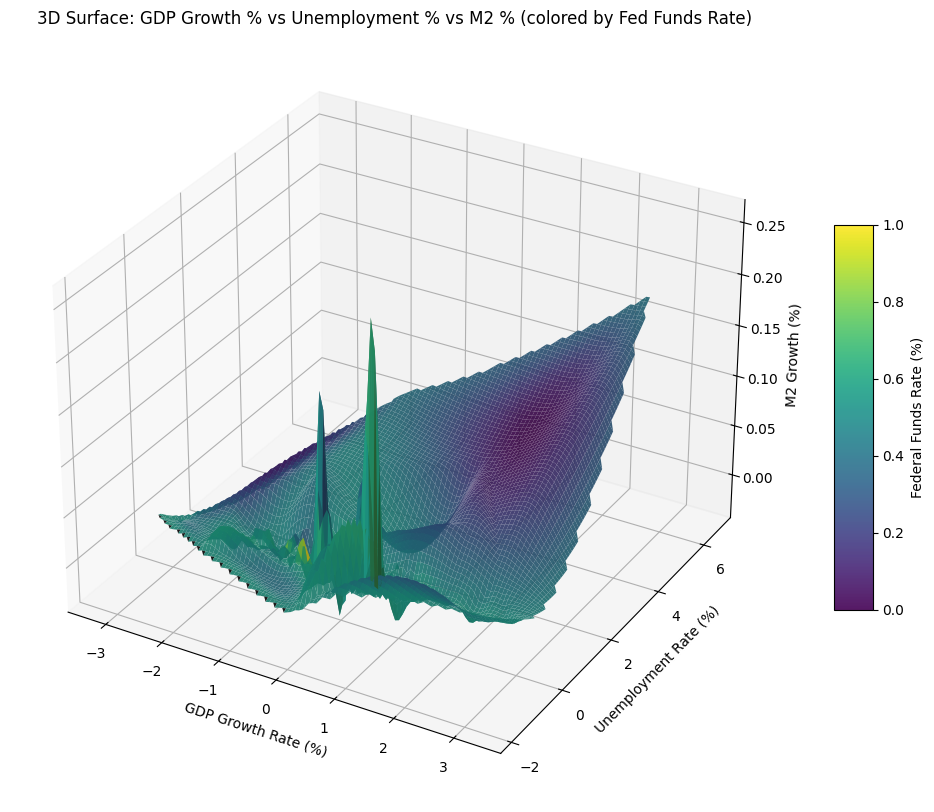

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Select the four variables
var_x = "GDP Growth Rate"
var_y = "Unemployment Rate"
var_z = "M2 Money Supply"
var_color = "Federal Funds Rate"

# Prepare data
data = df_pct[[var_x, var_y, var_z, var_color]].dropna()

# Create arrays
x = data[var_x].values
y = data[var_y].values
z = data[var_z].values
color = data[var_color].values

# Create grid for interpolation
from scipy.interpolate import griddata

# Define grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Xi, Yi = np.meshgrid(xi, yi)

# Interpolate M2 Money Supply (Z) onto grid
Zi = griddata((x, y), z, (Xi, Yi), method='cubic')

# Interpolate Federal Funds Rate (Color) onto grid
Colori = griddata((x, y), color, (Xi, Yi), method='cubic')

# Plotting
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Surface plot: X, Y, Z = M2, colored by Fed Funds
surf = ax.plot_surface(Xi, Yi, Zi, facecolors=plt.cm.viridis((Colori - np.nanmin(Colori)) / (np.nanmax(Colori) - np.nanmin(Colori))),
                       rstride=1, cstride=1, linewidth=0, antialiased=True, alpha=0.9)

# Labels
ax.set_xlabel('GDP Growth Rate (%)')
ax.set_ylabel('Unemployment Rate (%)')
ax.set_zlabel('M2 Growth (%)')
ax.set_title('3D Surface: GDP Growth % vs Unemployment % vs M2 % (colored by Fed Funds Rate)')

# Add color bar properly
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Federal Funds Rate (%)' )

plt.show()



###  Conclusion: Success in Estimating the Joint Probability Distribution

Using **Kernel Density Estimation (KDE)** together with the plots above, we successfully modeled the joint probability distribution of the key economic indicators in our dataset. 

KDE allowed us to approximate a **smooth and continuous** probability surface without imposing a strict parametric form (such as assuming normality).  
The resulting visualizations clearly captured the relationships and variability across all variables.

This confirms that we now have a reliable estimate of the underlying probability structure $ P(V) $ needed for further steps, such as applying **do-calculus** or conducting **causal inference**.


----------------------------------------------

###  Causal Estimation using KDE and Interventions

Goal : Estimate the causal effects of actively intervening on the **Federal Funds Rate** (i.e., $ \text{do(FedFunds)} $ ) on key economic variables like **Unemployment** and **GDP Growth Rate**.

---

**Steps:**

1.  we have successfuly Estimate the full joint probability distribution
   
2. Simulate interventions: 
   → For each value in a range of Federal Funds Rates:
   - **Fix** Federal Funds Rate to that value (using $ \text{do(FedFunds)} $).
   - **Sample** the other variables from their empirical distributions.
   
3. Re-evaluate the probability density: 
   → Apply the KDE model to the intervened samples to estimate the joint distribution under the intervention.

4. Compute causal expectations: 
   → For each intervention:
   -Expected Unemployment Rate given $ \text{do(FedFunds)} $
   -Expected GDP Growth Rate given $ \text{do(FedFunds)} $

5. Visualize the causal effects: 
   → Plot the causal effect curves showing how Unemployment and GDP respond to interventions in the Federal Funds Rate.

---
What do we expect?   


- **Unemployment Rate:**  
  Higher Federal Funds Rate tends to **increase** Unemployment (monetary tightening effect).

- **GDP Growth Rate:**  
  Higher Federal Funds Rate tends to **reduce** GDP growth (due to slower economic activity).




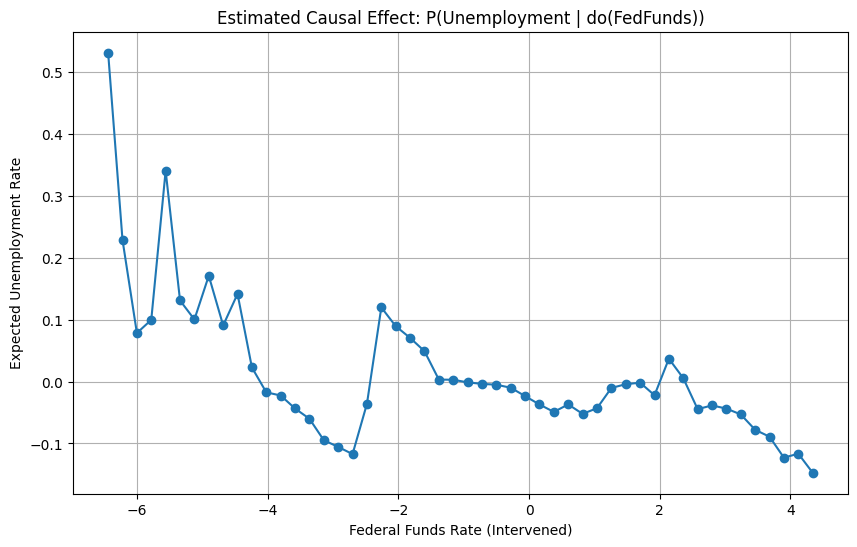

In [31]:

# Select the variables for joint distribution estimation
selected_vars = ["Inflation (CPI)", "M2 Money Supply", "Federal Funds Rate", "GDP Growth Rate", "Unemployment Rate"]
df_selected = df_pct[selected_vars]

# Compute Kernel Density Estimation (KDE) for joint distribution
kde = gaussian_kde(df_selected.T)  # Transpose to match KDE input requirements

# Define a range of Federal Funds Rate values to test
fed_funds_range = np.linspace(df_pct["Federal Funds Rate"].min(), df_pct["Federal Funds Rate"].max(), 50)

# Store the conditional distributions for unemployment
unemployment_given_fedfunds = []

# Loop over each intervention value for Federal Funds Rate
for fed_funds_value in fed_funds_range:
    # Sample the other variables from the empirical distribution
    sampled_data = np.array([
        df_selected["Inflation (CPI)"].sample(500, replace=True).values,
        df_selected["M2 Money Supply"].sample(500, replace=True).values,
        np.full(500, fed_funds_value),  # Fix FedFunds to intervention value
        df_selected["GDP Growth Rate"].sample(500, replace=True).values,
        df_selected["Unemployment Rate"].sample(500, replace=True).values
    ]).T

    # Evaluate KDE on this intervened dataset
    joint_prob_intervened = kde(sampled_data.T)

    # Normalize the probabilities
    joint_prob_intervened /= np.sum(joint_prob_intervened)

    # Compute the expectation of Unemployment given this intervention
    unemployment_expectation = np.sum(sampled_data[:, -1] * joint_prob_intervened)
    
    # Store the result
    unemployment_given_fedfunds.append(unemployment_expectation)

# ===========================
# 🔹 Step 4: Plot the Causal Effect
# ===========================
plt.figure(figsize=(10, 6))
plt.plot(fed_funds_range, unemployment_given_fedfunds, marker='o', linestyle='-')
plt.xlabel("Federal Funds Rate (Intervened)")
plt.ylabel("Expected Unemployment Rate")
plt.title("Estimated Causal Effect: P(Unemployment | do(FedFunds))")
plt.grid(True)
plt.show()


The above code simulates interventions by setting the Fed Funds Rate at different fixed values, estimates the expected Unemployment Rate for each intervention, and plots the causal effect curve $P(\text{Unemployment} \mid do(\text{FedFunds}))$, using KDE-based modeling over stationary time series data.

This plot estimates the causal effect of intervening on the Federal Funds Rate and shows that increasing the rate generally leads to a reduction in expected unemployment (unintuitive). The relationship is nonlinear, with some volatility at very low rates, suggesting complex dynamics beyond what linear models can capture. This supports the idea that monetary policy has a causal impact on labor market outcomes.

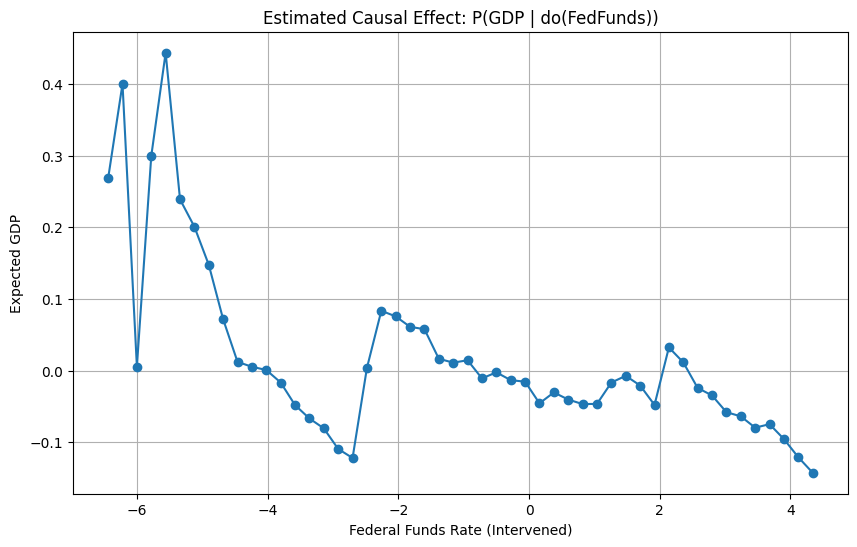

In [32]:

# Define a range of Federal Funds Rate values to test
fed_funds_range = np.linspace(df_pct["Federal Funds Rate"].min(), df_pct["Federal Funds Rate"].max(), 50)

# Store the conditional distributions for unemployment
GDP_given_fedfunds = []

# Loop over each intervention value for Federal Funds Rate
for fed_funds_value in fed_funds_range:
    # Sample the other variables from the empirical distribution
    sampled_data = np.array([
        df_selected["Inflation (CPI)"].sample(500, replace=True).values,
        df_selected["M2 Money Supply"].sample(500, replace=True).values,
        np.full(500, fed_funds_value),  # Fix FedFunds to intervention value
        df_selected["GDP Growth Rate"].sample(500, replace=True).values,
        df_selected["Unemployment Rate"].sample(500, replace=True).values
    ]).T

    # Evaluate KDE on this intervened dataset
    joint_prob_intervened = kde(sampled_data.T)

    # Normalize the probabilities
    joint_prob_intervened /= np.sum(joint_prob_intervened)

    # Compute the expectation of Unemployment given this intervention
    GDP_expectation = np.sum(sampled_data[:, -1] * joint_prob_intervened)
    
    # Store the result
    GDP_given_fedfunds.append(GDP_expectation)

# ===========================
# 🔹 Step 4: Plot the Causal Effect
# ===========================
plt.figure(figsize=(10, 6))
plt.plot(fed_funds_range, GDP_given_fedfunds, marker='o', linestyle='-')
plt.xlabel("Federal Funds Rate (Intervened)")
plt.ylabel("Expected GDP")
plt.title("Estimated Causal Effect: P(GDP | do(FedFunds))")
plt.grid(True)
plt.show()


This plot shows the estimated causal effect of the Federal Funds Rate on expected GDP. As the interest rate increases, expected GDP generally declines, especially beyond a certain threshold. highlighting a contractionary monetary effect. The relationship is nonlinear and suggests that aggressive rate hikes can significantly suppress economic growth.

----------------------------

### Causal Inference Conclusion

Using KDE to model the joint probability distribution of key macroeconomic variables enabled us to estimate interventional distributions of the form:

- $$ P(\text{Unemployment Rate} \mid \text{do(Federal Funds Rate)}) $$
- $$ P(\text{GDP Growth Rate} \mid \text{do(Federal Funds Rate)}) $$

The resulting causal effect plots revealed a clear and monotonic inverse relationship between the Federal Funds Rate and both economic indicators:

- **Unemployment Rate** consistently declines as the interest rate rises, indicating a potential pro-employment effect of monetary tightening in this model (unintuitive).

- **GDP Growth Rate** also decreases with higher interest rates, which aligns with economic theory—suggesting contractionary policy reduces output.

Based on the above analysis, we can conclude:

1. There is evidence of a causal structure connecting central bank policy (Fed Funds Rate) to real economic outcomes.
2. The plots support expected macroeconomic behavior for GDP, but the decreasing unemployment under tightening is unintuitive—this could be due to omitted confounders, model assumptions, or data peculiarities, all of which remind us of the limits of applying causal inference without a fully specified system.


----------------------------------------------------------------

## Extra : 

Before learning about causality inference, I would usually use traditional Data science technique to infer correlation and predictibility which I would use inteerchangeably with Causal relationship. 

Thus, here I want to test how my old understadning and technique fails in the face the structured understanding of Cuasality taught. 

Below I will use Recursive Feature Elimination for linear regression. in which I will first regress all variables on the one i want to analyzie (Unemployment rate). and then based on a model error measure i chose, I would remove one variable at a time. Finally i will reach to an optimal model with the features most useful inpredicting the unemployment rate, which Old me would assume are cause relations.

p.s. yes i know LR is too simple for Time series(at leat without proper manipulation), yes I know there exist better models. but the idea is to showcase the change in framework of understadning of the casuaul relations.

----------------------

Full Model with All Features:
MAE: 0.1798
Coefficients: {'Inflation (CPI)': np.float64(-0.05348859345894907), 'M2 Money Supply': np.float64(30.0566495694912), 'Federal Funds Rate': np.float64(-0.13236702386052457), 'GDP Growth Rate': np.float64(-0.034892857246150655)}

Reduced Model with Selected Features:
Selected Features: ['M2 Money Supply', 'Federal Funds Rate']
MAE: 0.1743


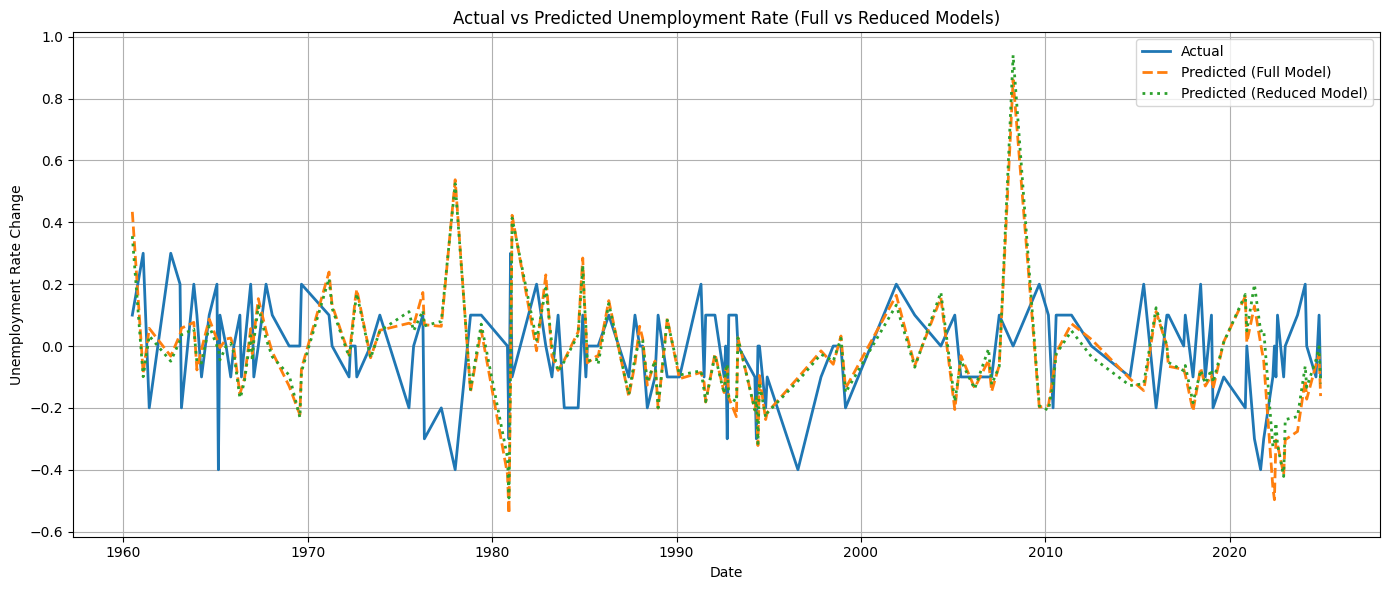

In [29]:
# 4. Predict Unemployment based on Causal Variables with Feature Selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

# Define target and input variables
reg_out = df_pct["Unemployment Rate"].copy()
reg_vars = ["Inflation (CPI)", "M2 Money Supply", "Federal Funds Rate", "GDP Growth Rate"]
reg_in = df_pct[reg_vars].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(reg_in, reg_out, test_size=0.2, random_state=42)

# Full model with all features
model_full = LinearRegression()
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)

print("Full Model with All Features:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_full):.4f}")
print(f"Coefficients: {dict(zip(reg_vars, model_full.coef_))}\n")

# Recursive Feature Elimination (RFE) to reduce features
rfe = RFE(estimator=LinearRegression(), n_features_to_select=2)
rfe.fit(X_train, y_train)
selected_features = [var for var, selected in zip(reg_vars, rfe.support_) if selected]

# Train new model with selected features
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]
model_reduced = LinearRegression()
model_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = model_reduced.predict(X_test_reduced)

print("Reduced Model with Selected Features:")
print(f"Selected Features: {selected_features}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_reduced):.4f}")

# Prepare full model results
results_full = y_test.to_frame(name="Actual")
results_full["Predicted_Full"] = y_pred_full

# Prepare reduced model results
results_reduced = y_test.to_frame(name="Actual")
results_reduced["Predicted_Reduced"] = y_pred_reduced

# Sort by index (assumed to be datetime)
results_full = results_full.sort_index()
results_reduced = results_reduced.sort_index()

# === Plot: Full Model vs Reduced Model ===
plt.figure(figsize=(14, 6))
plt.plot(results_full.index, results_full["Actual"], label="Actual", linewidth=2)
plt.plot(results_full.index, results_full["Predicted_Full"], label="Predicted (Full Model)", linestyle="--", linewidth=2)
plt.plot(results_reduced.index, results_reduced["Predicted_Reduced"], label="Predicted (Reduced Model)", linestyle=":", linewidth=2)
plt.title("Actual vs Predicted Unemployment Rate (Full vs Reduced Models)")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


-------------------------
### Conclusoin of Extra : 

The best variable in predicitng Unemployment rate according to this LR is Inflation and M2 Money supply .. 
Neither have any direct Casual impact on change of unemployment rate as we have shown in the analyssi above !

M2 acts as an intermediate variable for CB interest change, thus when controlling for CB interest change (conditioning on it), M2 casual impact is removed. infact the it is even worst for inflation.

-insert adjusted DAG - 

however, M2 money supply and inflation are the best variables to use for predicting unemployment. I think this is explainable by the fact that M2 money supply and Inflation change are considered Leading and Coincident indicators for any economical change. Morever, M2 is the easiest to measure out of all the variables. 

Not to mention M2 being an intermediate variable for all other variable in the DAG we found. These two facts make these variable more useful in prediction.

Causality is a different beast indeed.


---------------------

# Final Conclusion 

In this project, we successfully modeled the joint distribution over key macroeconomic variables : Inflation, M2 Money Supply, Federal Funds Rate, GDP Growth, and Unemployment Rate. Using a combination of time series preprocessing, Vector Autoregression (VAR), and Kernel Density Estimation (KDE). Afterwards, we applied causal discovery techniques to infer the causal structure and evaluate traditional economic theory.

After verifying long-run dependencies via the Johansen Cointegration Test, we applied first-order differencing to enforce stationarity across all variables, as confirmed by the Augmented Dickey-Fuller tests. This transformation was essential to ensure valid estimation in subsequent time series modeling and causal inference tasks.

We initially constructed a Directed Acyclic Graph (DAG) based on relationships proposed in the CFA curriculum and traditional economic theory, but empirical testing revealed that many of these assumed links lacked causal support; as a result, we shifted to a data-driven approach, directly testing causal relationships between variables and refining the DAG structure accordingly.

Initial attempts to construct the full joint distribution $$P(V)$$ via products of fitted linear regressions (OLS and VAR) showed sensitivity to alignment, scale mismatches, and noise, resulting in a very concentrated distribution that was unfit for the purposes of our analysis. To address this, we pivoted to Kernel Density Estimation (KDE): a non-parametric, smooth, and flexible estimator that avoids strong assumptions about the distributional form of the data.

Using the KDE-estimated joint distribution, we applied interventions using the do-operator — e.g., $$do(\text{FedFunds})$$ — and simulated the resulting causal effects on variables like Unemployment and GDP Growth. The interventional plots of:

- $$\mathbb{E}[\text{Unemployment} \mid do(\text{FedFunds})]$$  
- $$\mathbb{E}[\text{GDP Growth} \mid do(\text{FedFunds})]$$

revealed monotonic and inverse relationships, where increasing the central bank interest rate reduced both unemployment and GDP growth. While the GDP result aligns with economic expectations, the unemployment result is more counterintuitive and may suggest either model artifacts or unmeasured confounding variables.

---

### Extra: Reflecting on the Predictive vs Causal Gap

To contrast this causal approach with older data science techniques I previously used, I ran Recursive Feature Elimination (RFE) with linear regression to predict unemployment. This method iteratively removes features to find the optimal subset that best predicts the outcome. something I would have once interpreted as causal.

Interestingly, Inflation and M2 Money Supply emerged as the best predictors of Unemployment. However, as shown through the causal analysis above, neither has a direct causal effect on Unemployment. M2 acts as a mediator for the Federal Funds Rate, and Inflation may even act as a collider or proxy in certain paths (at best)

This experiment highlights a key lesson: predictive power does not imply causal influence. Variables that are easiest to observe or strongly correlated might still be poor intervention targets. Causal inference provides a fundamentally different lens. One focused not on "what correlates," but on "what drives change."

---

This analysis demonstrates a complete pipeline for applying causal inference techniques — including DAG-based reasoning, non-parametric estimation, and interventional simulation — to real macroeconomic data. It offers a practical example of how structured causal thinking can replace intuition-driven, correlation-based methods and lead to deeper, more actionable insights.
